# Resales Price Prediction

### Import Packages

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt

In [2]:
pd.set_option('display.max_rows', 50)

current_year = 2024
year_cutoff = 2015

### New resale data reduced from 191586 rows to 191256 rows

In [3]:
new_resales = pd.read_csv('newresales_dataset.csv')
print(f'Data has {new_resales.shape[0]} rows', '\n')
print('Missing Data')
new_resales.isna().sum()

Data has 191256 rows 

Missing Data


Unnamed: 0             0
year                   0
date                   0
town                   0
flat_type              0
block                  0
street_name            0
storey_range           0
floor_area_sqm         0
flat_model             0
lease_commence_date    0
resale_price           0
remaining_lease        0
flat_type_group        0
region                 0
price/sqm              0
lat                    0
lng                    0
postal                 0
nearest_mrt            0
mrt_dist               0
nearest_shopping       0
shopping_dist          0
nearest_school         0
school_dist            0
nearest_hawker         0
hawker_dist            0
dtype: int64

### Checking for hints of multicollinearity

*Some positive correlation between hawker_dist and remaining_lease strangely.*

*It is likely not substantial enough to cause multicollinearity issues.*

*Decent linear relationship between resale_price and multiple variables,
including year, storey_range, remaining_lease (expected)
highest of which is floor_area, as expected.*

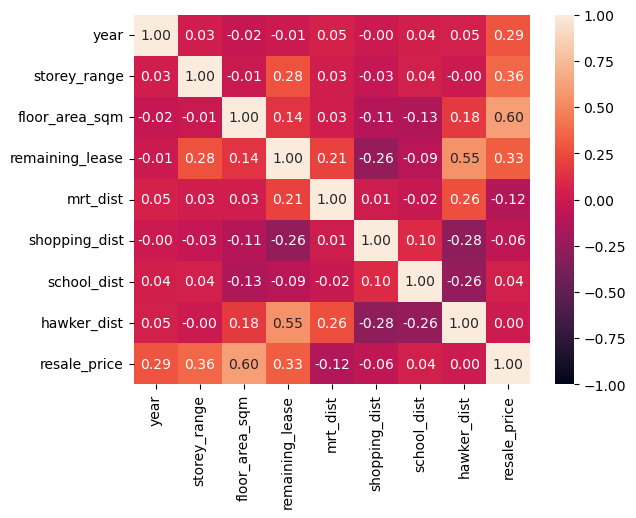

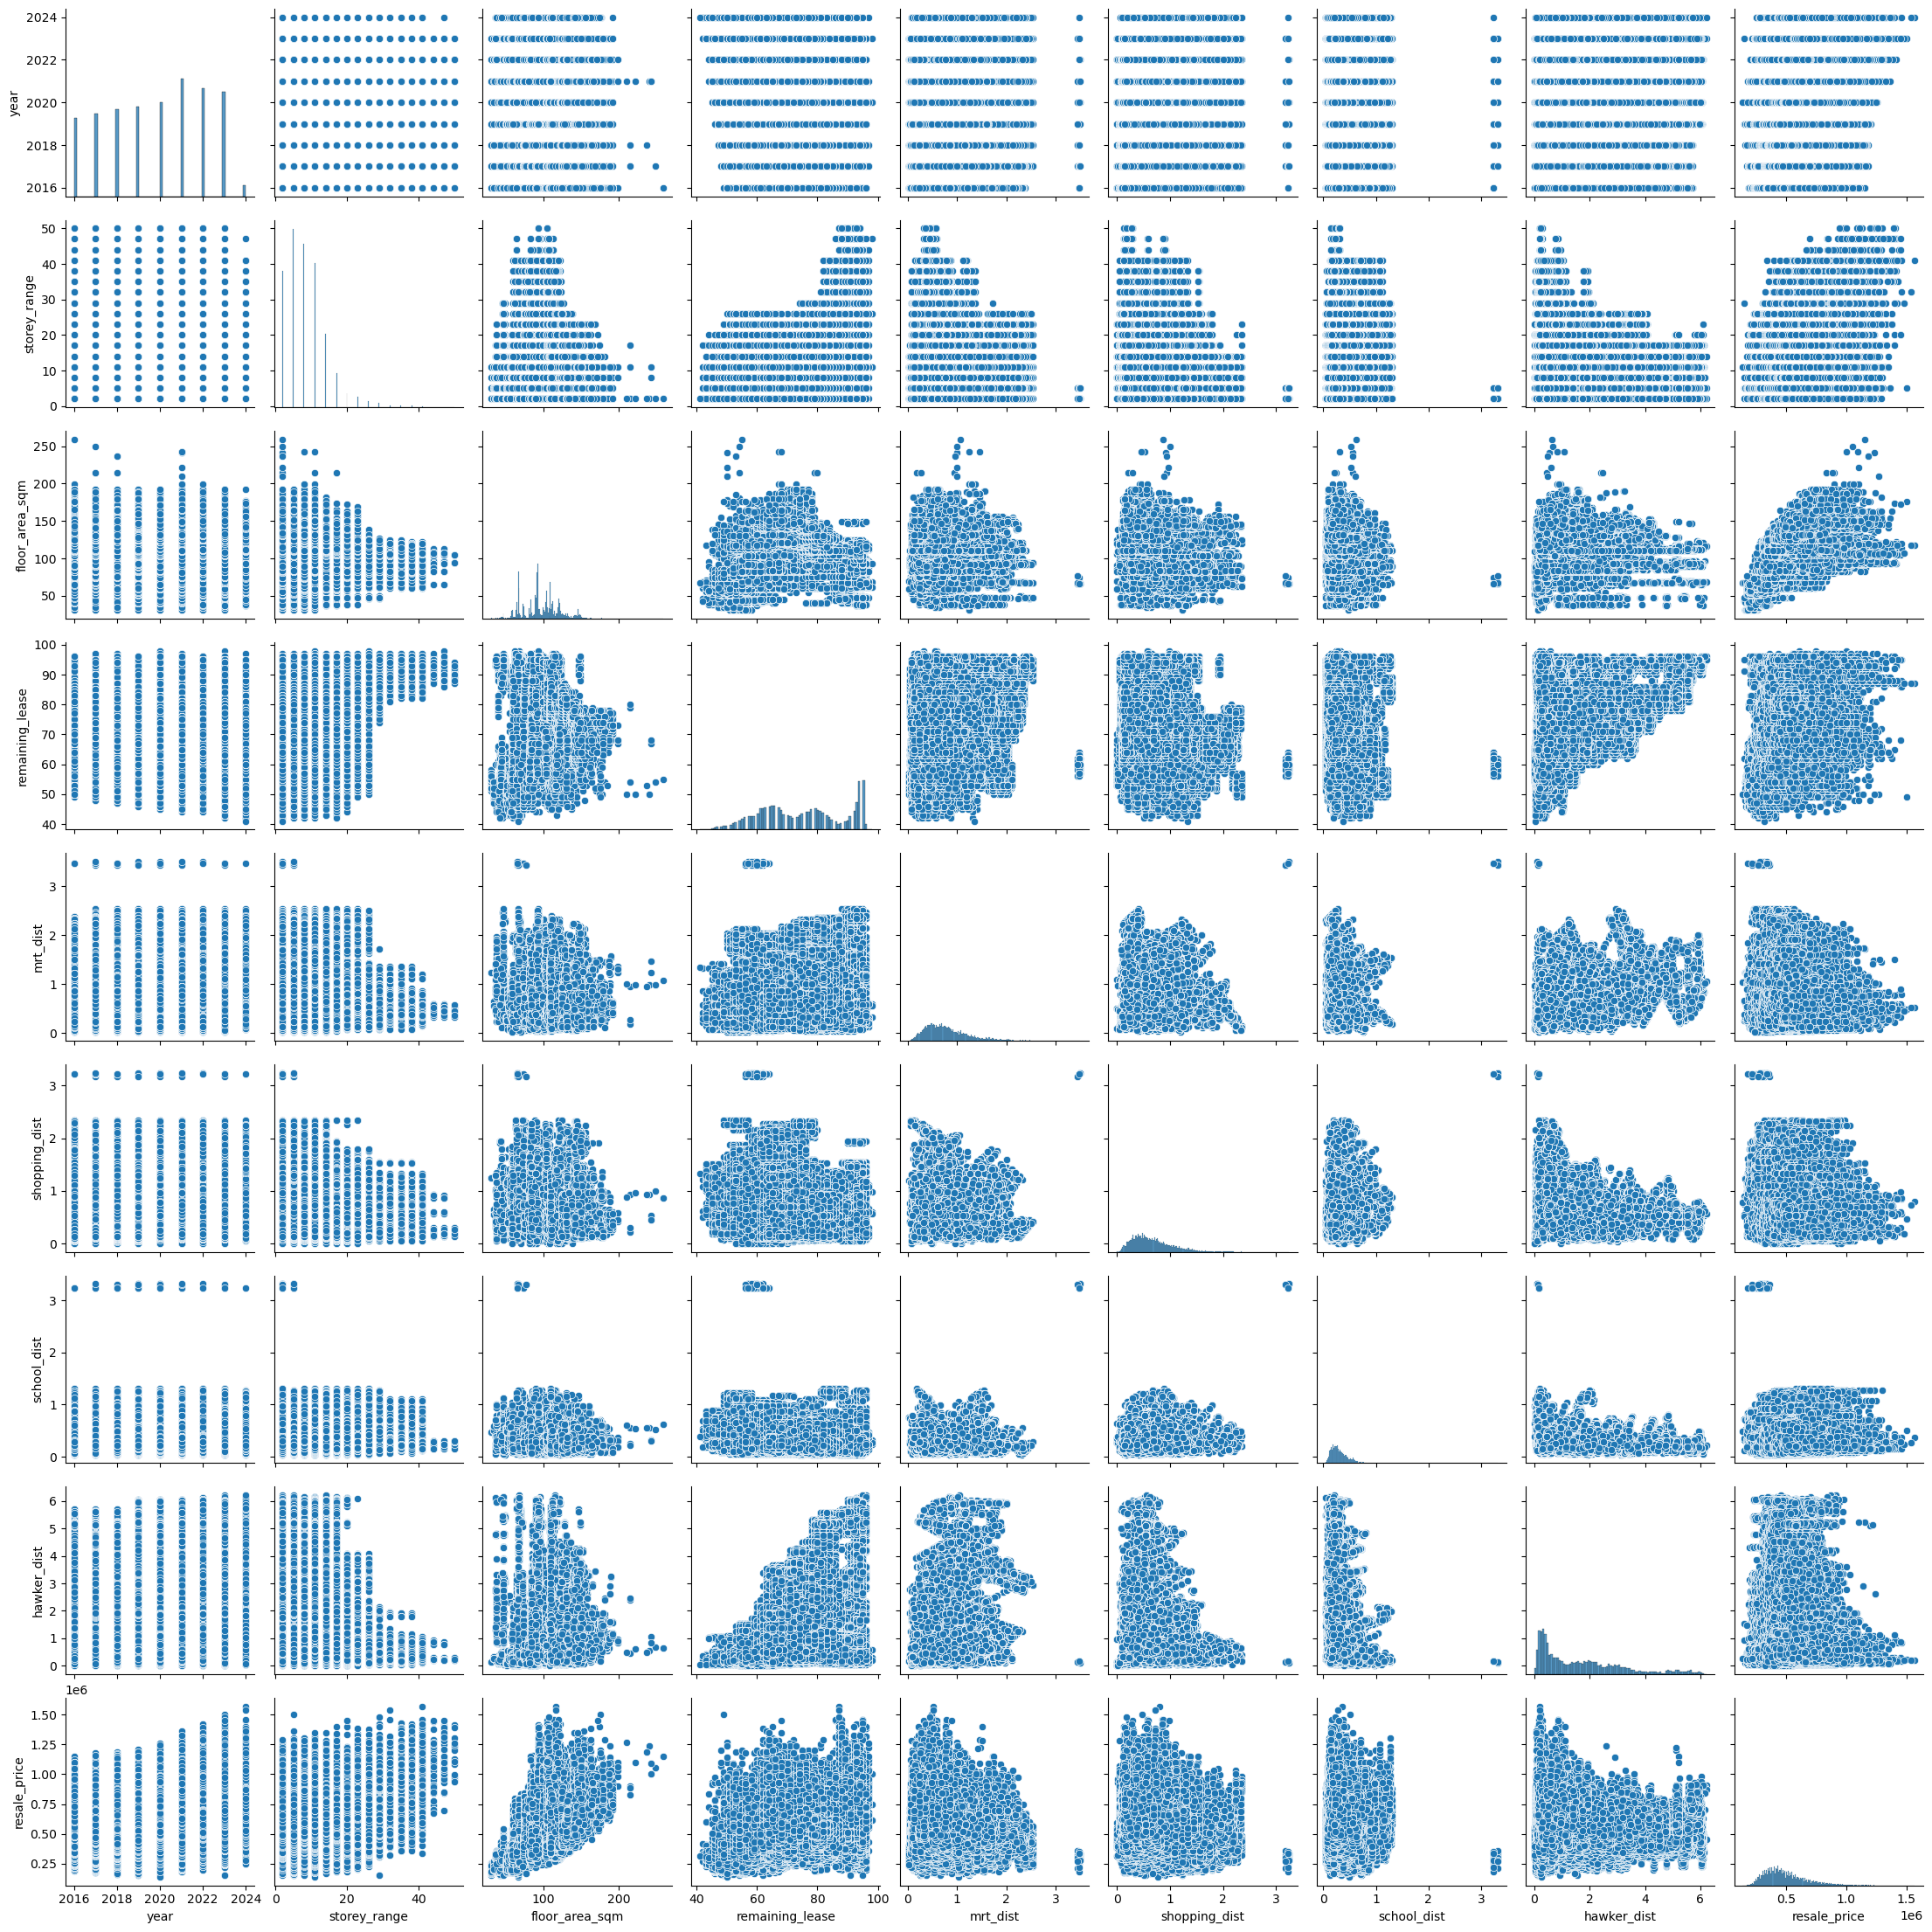

In [4]:
regression_columns = ['year', 'town', 'flat_type', 'storey_range', 'floor_area_sqm', 
    'remaining_lease', 'mrt_dist', 'shopping_dist', 'school_dist', 'hawker_dist', 'resale_price']

new_resales_reg = new_resales[regression_columns]

sns.heatmap(new_resales_reg.corr(), vmin=-1, vmax=1, annot=True, 
            fmt=".2f", annot_kws={"size": 10})
sns.pairplot(new_resales_reg)

### Data Preprocessing

In [5]:
original_col = pd.get_dummies(new_resales_reg).columns
new_resales_reg = pd.get_dummies(new_resales_reg, drop_first=True)

# Uncomment above to try other dummy variables
# new_resales_reg  = pd.get_dummies(new_resales_reg).drop(columns=['flat_type_2 ROOM', 'town_ANG MO KIO'])  

dummy_var = set(original_col) - set(new_resales_reg.columns)

# Rename some columns to get smf.ols to read x variables properly
new_resales_reg.columns = new_resales_reg.columns.str.replace(' ','_')
new_resales_reg.rename(columns={'price/sqm':'Price_per_sqm',
                                'town_KALLANG/WHAMPOA':'town_KALLANG_WHAMPOA',
                                'flat_type_MULTI-GENERATION':'flat_type_MULTI_GENERATION'},
                       inplace=True)

# Subtract year by 2024 to simplify analysis of coefficients
new_resales_reg['year'] = new_resales_reg['year'] - current_year

###  Regression: Simple

*Adjusted R^2 0.862, 3-room and 4-room flats non-significant at 1% level*

*Interestingly, the coefficient of school_dist is positive*

                            OLS Regression Results                            
Dep. Variable:           resale_price   R-squared:                       0.861
Model:                            OLS   Adj. R-squared:                  0.860
Method:                 Least Squares   F-statistic:                 3.024e+04
Date:                Mon, 15 Apr 2024   Prob (F-statistic):               0.00
Time:                        17:14:33   Log-Likelihood:            -2.3846e+06
No. Observations:              191256   AIC:                         4.769e+06
Df Residuals:                  191216   BIC:                         4.770e+06
Df Model:                          39                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept           

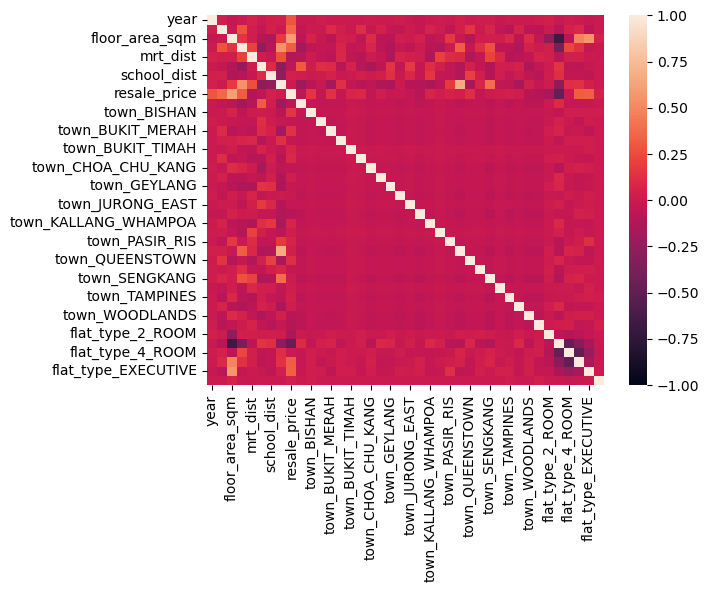

In [6]:
x_variables = list(new_resales_reg.columns)
y_variable = 'resale_price'
try: x_variables.remove(y_variable)
except ValueError: pass

# Exporting the correlation matrix, too large to visualize
sns.heatmap(new_resales_reg.corr(), vmin=-1, vmax=1)
new_resales_reg[x_variables].corr().to_csv('correl.csv')


linear_model = smf.ols(data=new_resales_reg, formula=f'{y_variable} ~ {"+".join(x_variables)}').fit()
print(linear_model.summary())
print(f'Dummy Variables: {dummy_var}')

### Regression: Changing y variable to log

*Adjusted R^2 0.888, all variables significant.*

*Since R^2 increased significantly, we keep log(y)*

In [7]:
linear_model = smf.ols(data=new_resales_reg, formula=f'np.log({y_variable}) ~ {"+".join(x_variables)}').fit()
print(linear_model.summary())
print(f'Dummy Variables: {dummy_var}')

# Adj R2 0.888, all variables significant. 
# Since R2 increased significantly, we keep log(y)

                             OLS Regression Results                             
Dep. Variable:     np.log(resale_price)   R-squared:                       0.888
Model:                              OLS   Adj. R-squared:                  0.888
Method:                   Least Squares   F-statistic:                 3.871e+04
Date:                  Mon, 15 Apr 2024   Prob (F-statistic):               0.00
Time:                          17:14:34   Log-Likelihood:             1.4786e+05
No. Observations:                191256   AIC:                        -2.956e+05
Df Residuals:                    191216   BIC:                        -2.952e+05
Df Model:                            39                                         
Covariance Type:              nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------


### Regression: Adding quadratic terms to numerical variables

*Adjusted R^2 0.889, not much difference.*

*Remaining_lease ** 2 is not significant, the others are.*

*We prefer model simplicity hence we drop the quadratic terms.*

In [8]:
var = ['storey_range', 'remaining_lease', 'floor_area_sqm']
string = ''.join(map(lambda x: ' + I(' + x + '**2)', var))

linear_model = smf.ols(data=new_resales_reg, 
    formula=f'np.log({y_variable}) ~ {"+".join(x_variables)}' + string).fit()
print(linear_model.summary())
print(f'Dummy Variables: {dummy_var}')

                             OLS Regression Results                             
Dep. Variable:     np.log(resale_price)   R-squared:                       0.888
Model:                              OLS   Adj. R-squared:                  0.888
Method:                   Least Squares   F-statistic:                 3.618e+04
Date:                  Mon, 15 Apr 2024   Prob (F-statistic):               0.00
Time:                          17:14:35   Log-Likelihood:             1.4841e+05
No. Observations:                191256   AIC:                        -2.967e+05
Df Residuals:                    191213   BIC:                        -2.963e+05
Df Model:                            42                                         
Covariance Type:              nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------


### Regression: Adding interaction variables between flat_type and floor_area

*Adjusted R^2 0.891, all variables significant.*

*We still prefer simpler model since not much difference.*

*Attempted to use interaction variables [year, storey_range, remaining_lease] but results are not significant.*


In [9]:
var = ['2_ROOM', '3_ROOM', '4_ROOM', '5_ROOM', 'EXECUTIVE', 'MULTI_GENERATION']
interaction_var = 'floor_area_sqm'
# interaction_var = 'remaining_lease'

string = ''.join(map(lambda x: f' + {interaction_var} : flat_type_' + x, var))

linear_model = smf.ols(data=new_resales_reg, 
    formula=f'np.log({y_variable}) ~ {"+".join(x_variables)}' + string).fit()
print(linear_model.summary())
print(f'Dummy Variables: {dummy_var}')


                             OLS Regression Results                             
Dep. Variable:     np.log(resale_price)   R-squared:                       0.890
Model:                              OLS   Adj. R-squared:                  0.890
Method:                   Least Squares   F-statistic:                 3.521e+04
Date:                  Mon, 15 Apr 2024   Prob (F-statistic):               0.00
Time:                          17:14:36   Log-Likelihood:             1.5006e+05
No. Observations:                191256   AIC:                        -3.000e+05
Df Residuals:                    191211   BIC:                        -2.996e+05
Df Model:                            44                                         
Covariance Type:              nonrobust                                         
                                                coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------

### Regression: Trying a different date range. In particular, we try the Covid years (2020 onwards)

*R^2 improved to 0.918, showing that the smaller dataset works better to explain variance.*

*We keep this as final model.*

In [10]:
resales_after_2020 = new_resales_reg[new_resales_reg['year']>=(2020-current_year)].reset_index(drop=True)

linear_model = smf.ols(data=resales_after_2020, 
    formula=f'np.log({y_variable}) ~ {"+".join(x_variables)}').fit()
print(linear_model.summary())
print(f'Dummy Variables: {dummy_var}')

                             OLS Regression Results                             
Dep. Variable:     np.log(resale_price)   R-squared:                       0.918
Model:                              OLS   Adj. R-squared:                  0.918
Method:                   Least Squares   F-statistic:                 3.075e+04
Date:                  Mon, 15 Apr 2024   Prob (F-statistic):               0.00
Time:                          17:14:37   Log-Likelihood:             1.0367e+05
No. Observations:                107627   AIC:                        -2.073e+05
Df Residuals:                    107587   BIC:                        -2.069e+05
Df Model:                            39                                         
Covariance Type:              nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------


#### Exporting the correlation matrix, too large to visualize

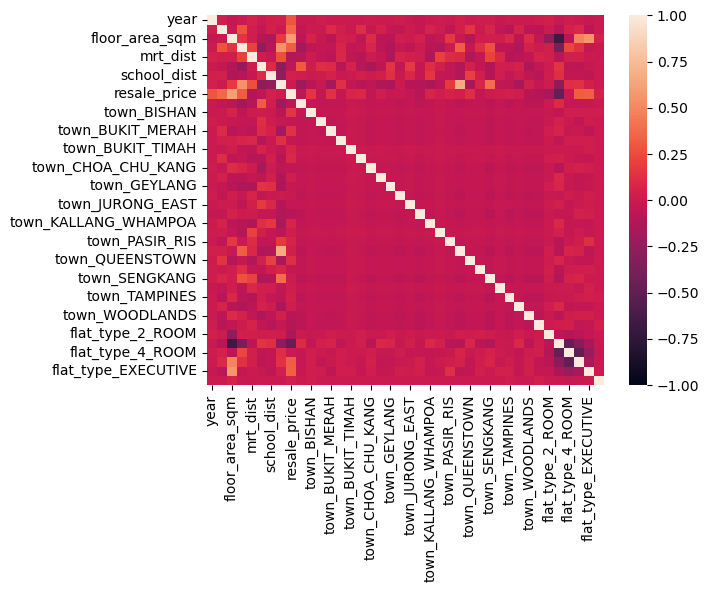

In [11]:
sns.heatmap(new_resales_reg.corr(), vmin=-1, vmax=1)
new_resales_reg[x_variables].corr().to_csv('correl.csv')

### Residual Analysis for Heteroscedasticity

*In general variance of residuals seem constant for most variables*

*Only residuals vs storey_range shows a decreasing variance.*

*We tried including storey_range**2 and interaction variables with storey_range, did not change the residual plot.*

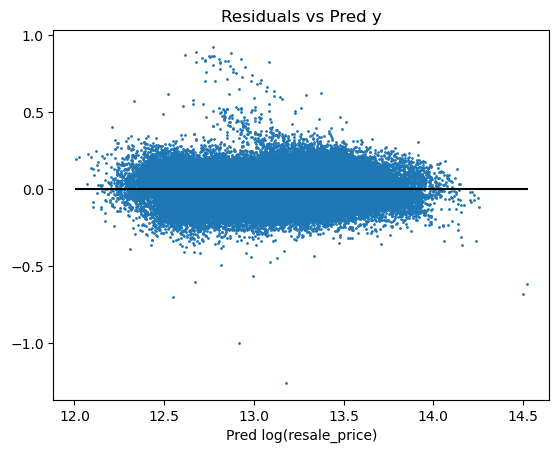

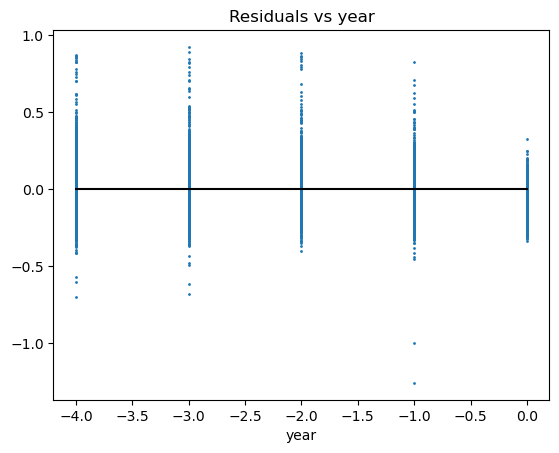

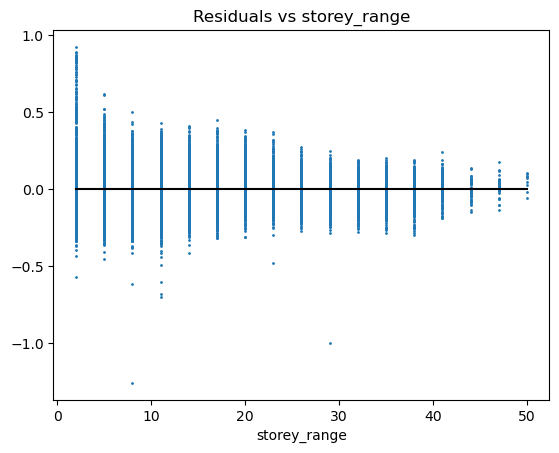

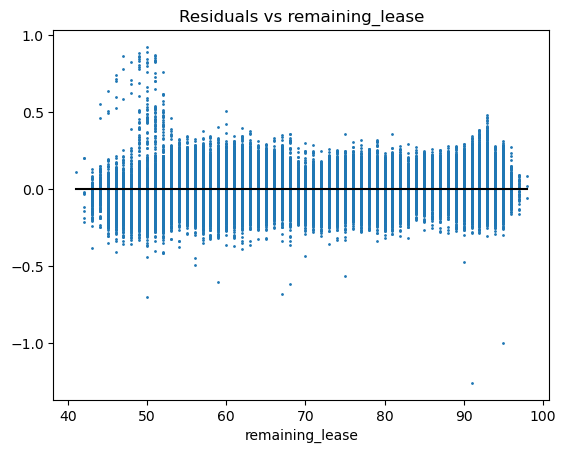

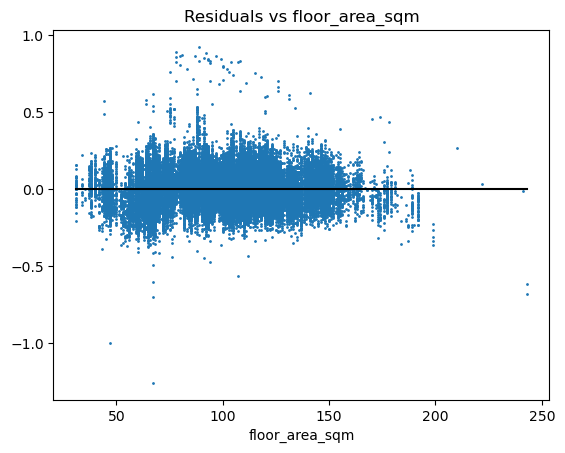

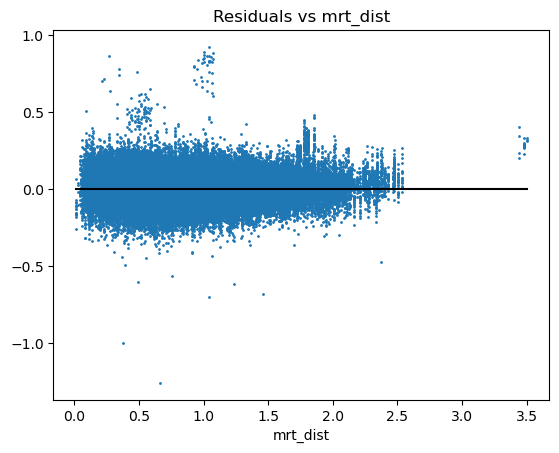

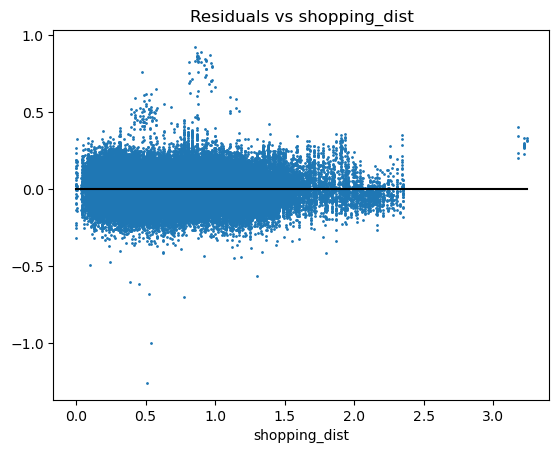

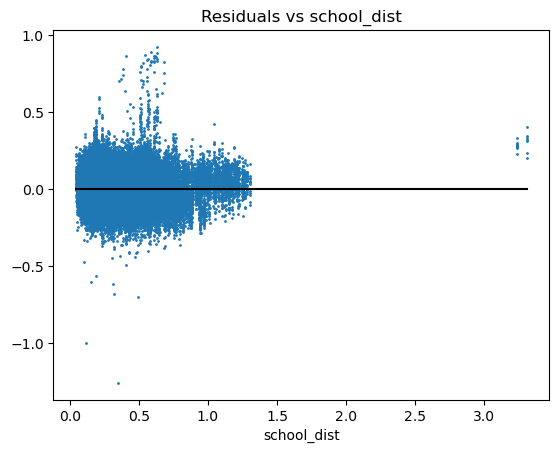

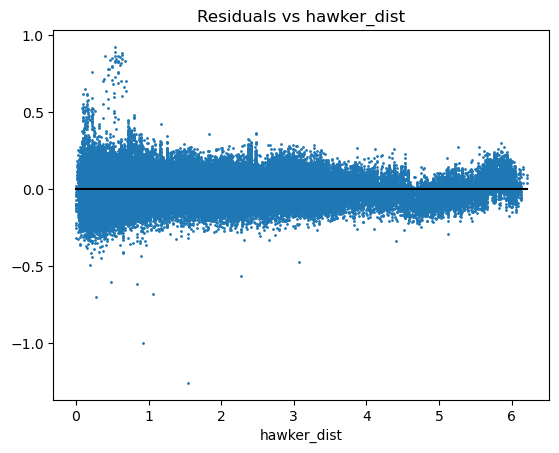

In [12]:
pred_y = linear_model.fittedvalues
plt.scatter(pred_y, linear_model.resid, s=1)
plt.plot([min(pred_y),max(pred_y)],[0,0], color='black')
plt.title('Residuals vs Pred y')
plt.xlabel('Pred log(resale_price)')
plt.show()

for var in ['year', 'storey_range', 'remaining_lease', 'floor_area_sqm', 
            'mrt_dist', 'shopping_dist', 'school_dist', 'hawker_dist']:
    plt.scatter(resales_after_2020[var], linear_model.resid, s=1)
    plt.plot([min(resales_after_2020[var]),max(resales_after_2020[var])],[0,0], color='black')
    plt.title(f'Residuals vs {var}')
    plt.xlabel(var)
    plt.show()

### Train-test split over time series (train 4 year models, test 5th year) 

*The 4-year models perform quite well on test data, testing R2 from 0.77-0.91*
*Mean error usually below 4%, MAE 8%, RMSE 11%*

*Exception in 2021-2022 where the model underpredicted by about 10% on average, suggesting an abnormal surge in house prices during Covid.*

*There was also an exception in 2024, where the model overpredicted by 7%, could be due to cooling measures in 2023*
    

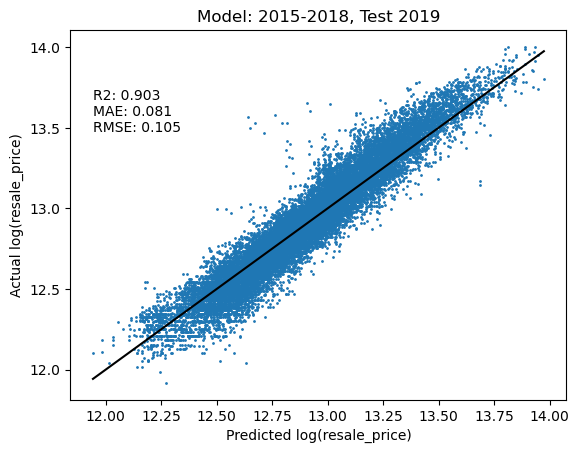

Model: 2015-2018 (61443 datapoints), Test 2019 (22186 datapoints)
R2: 0.903
MAE: 0.081
RMSE: 0.105



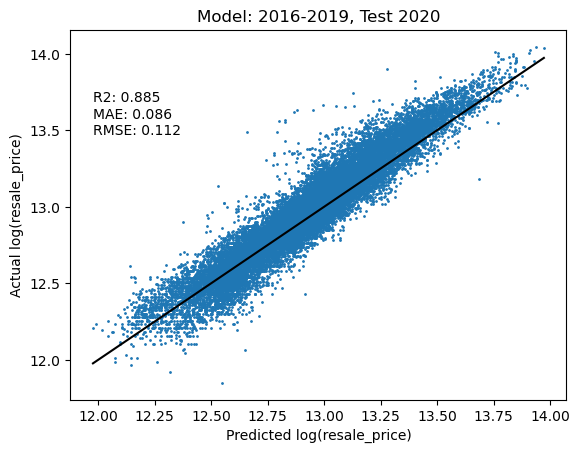

Model: 2016-2019 (83629 datapoints), Test 2020 (23333 datapoints)
R2: 0.885
MAE: 0.086
RMSE: 0.112



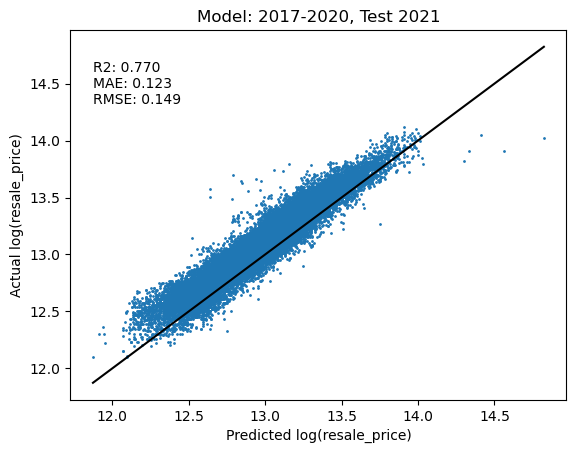

Model: 2017-2020 (87589 datapoints), Test 2021 (29087 datapoints)
R2: 0.770
MAE: 0.123
RMSE: 0.149



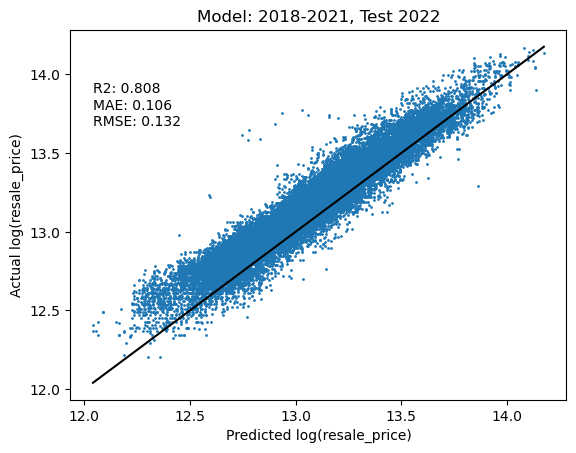

Model: 2018-2021 (96167 datapoints), Test 2022 (26720 datapoints)
R2: 0.808
MAE: 0.106
RMSE: 0.132



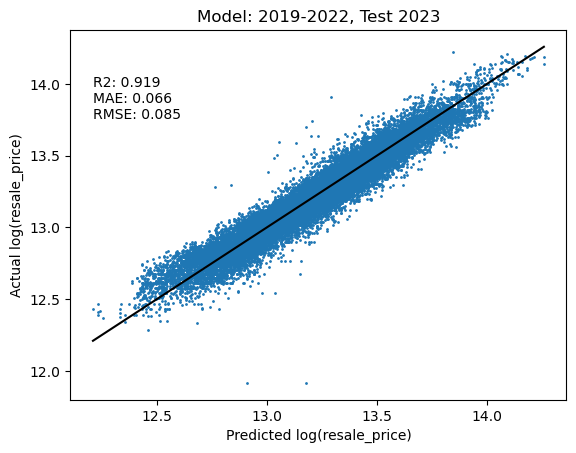

Model: 2019-2022 (101326 datapoints), Test 2023 (25771 datapoints)
R2: 0.919
MAE: 0.066
RMSE: 0.085



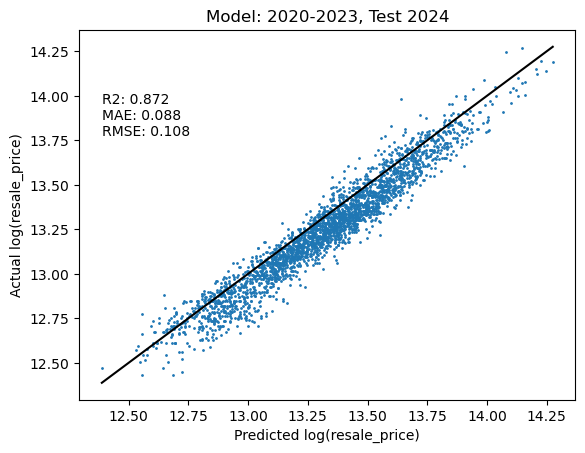

Model: 2020-2023 (104911 datapoints), Test 2024 (2716 datapoints)
R2: 0.872
MAE: 0.088
RMSE: 0.108



In [13]:
from sklearn.linear_model import LinearRegression

year_range = 4

new_resales_reg['flat_type_3_ROOM:floor_area_sqm'] = new_resales_reg['flat_type_3_ROOM'] * new_resales_reg['floor_area_sqm']

for start_year in range(2015, current_year - year_range + 1):
    train_df = new_resales_reg[(new_resales_reg['year'] >= start_year-current_year) & (new_resales_reg['year'] < start_year-current_year+year_range)]
    test_df = new_resales_reg[new_resales_reg['year'] == start_year-current_year+year_range]
    
    X_train = train_df.drop(columns=['resale_price']).to_numpy()
    y_train = np.log(train_df['resale_price'].to_numpy())
    X_test = test_df.drop(columns=['resale_price']).to_numpy()
    y_test = np.log(test_df['resale_price'].to_numpy())
    
    lm = LinearRegression()
    lm.fit(X_train, y_train)
    y_pred = lm.predict(X_test) 
    errors = y_pred - y_test
    
    plt.scatter(y_pred, y_test, s=1)
    plt.plot([min(y_pred),max(y_pred)], [min(y_pred),max(y_pred)], color='black')
    plt.annotate(f'R2: {lm.score(X_test, y_test):.3f} \nMAE: {np.abs(errors).mean():.3f} \nRMSE: {np.sqrt(np.square(errors).mean()):.3f}', 
                 (min(y_pred),max(y_pred)-0.5))
    plt.title(f'Model: {start_year}-{start_year+year_range-1}, Test {start_year+year_range}')
    plt.ylabel('Actual log(resale_price)')
    plt.xlabel('Predicted log(resale_price)')
    plt.show()
    
    print(f'Model: {start_year}-{start_year+year_range-1} ({train_df.shape[0]} datapoints), Test {start_year+year_range} ({test_df.shape[0]} datapoints)')
    print(f'R2: {lm.score(X_test, y_test):.3f}')
    print(f'MAE: {np.abs(errors).mean():.3f}')
    print(f'RMSE: {np.sqrt(np.square(errors).mean()):.3f}')
    print()

### Train-test split, cross-sectionally, for 2020-2023'

*R^2 above 0.92, MAE 7%, RMSE 9%*

In [14]:
from sklearn.model_selection import KFold

n_splits = 5  # For 5-fold split
kf = KFold(n_splits=n_splits, shuffle=True, random_state=6969)

# Prepare data
train_df = new_resales_reg[(new_resales_reg['year'] >= -4) & (new_resales_reg['year'] < 0)]
X = train_df.drop(columns=['resale_price']).to_numpy()
y = np.log(train_df['resale_price'].to_numpy())  # Log-transform y for training

fold = 0
for train_index, test_index in kf.split(X):
    fold += 1
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Train model
    lm.fit(X_train, y_train)
    
    # Predict and calculate errors
    y_pred = lm.predict(X_test)
    errors = y_pred - y_test
    
    print(f'Fold {fold}, {X_train.shape[0]} train datapoints, Test: {X_test.shape[0]} test datapoints')
    print(f'R2: {lm.score(X_test, y_test):.3f}')
    print(f'MAE: {np.abs(errors).mean():.3f}')
    print(f'RMSE: {np.sqrt(np.square(errors).mean()):.3f}')
    print()

Fold 1, 83928 train datapoints, Test: 20983 test datapoints
R2: 0.919
MAE: 0.071
RMSE: 0.091

Fold 2, 83929 train datapoints, Test: 20982 test datapoints
R2: 0.923
MAE: 0.070
RMSE: 0.090

Fold 3, 83929 train datapoints, Test: 20982 test datapoints
R2: 0.921
MAE: 0.071
RMSE: 0.091

Fold 4, 83929 train datapoints, Test: 20982 test datapoints
R2: 0.920
MAE: 0.070
RMSE: 0.090

Fold 5, 83929 train datapoints, Test: 20982 test datapoints
R2: 0.920
MAE: 0.070
RMSE: 0.091

